In [22]:
%%capture
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np

In [23]:
def densenet(img_shape, n_classes, f=32):
    repetitions = 6, 12, 24, 16
    
    def bn_rl_conv(x, f, k=1, s=1, p='same'):
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(f, k, strides=s, padding=p)(x)
        return x
  
   def dense_block(tensor, r):
        for _ in range(r):
            x = bn_rl_conv(tensor, 4*f)
            x = bn_rl_conv(x, f, 3)
            tensor = Concatenate()([tensor, x])
        return tensor
  
  
    def transition_block(x):
        x = bn_rl_conv(x, K.int_shape(x)[-1] // 2)
        x = AvgPool2D(2, strides=2, padding='same')(x)
        return x
  
  
    input = Input(img_shape)
    x = Conv2D(64, 7, strides=2, padding='same')(input)
    x = MaxPool2D(3, strides=2, padding='same')(x)
  
    for r in repetitions:
        d = dense_block(x, r)
        x = transition_block(d)
  
    x = GlobalAvgPool2D()(d)
  
    output = Dense(n_classes, activation='softmax')(x)
  
    model = Model(input, output)
    return model

In [24]:
input_shape = 48, 48, 3
n_classes = 7

K.clear_session()
model = densenet(input_shape, n_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 24, 24, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 12, 12, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 12, 12, 64)   256         max_pooling2d[0][0]              
______________________________________________________________________________________________

In [25]:
model.compile(optimizer="adam", 
               loss='categorical_crossentropy', 
               metrics=['accuracy'])

In [27]:
data_dir = 'FER+CK/train/'
val_dir = 'FER+CK/val/'
test_dir = 'FER_test/'

In [28]:
epochs = 300
batch_size = 32

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        shear_range=.2,
                        horizontal_flip=True,
                        validation_split=0.2)

train_generator = datagen_train.flow_from_directory(data_dir,
                                                    target_size=(48,48),
                                                    batch_size= batch_size,
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    shuffle=True)

datagen_val = ImageDataGenerator(featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        shear_range=.2,
                        horizontal_flip=True)

val_generator = datagen_val.flow_from_directory(val_dir,
                                                target_size=(48,48),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                color_mode='rgb',
                                                shuffle=False) 


Found 29430 images belonging to 7 classes.
Found 6723 images belonging to 7 classes.


In [30]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

my_callbacks = [
                EarlyStopping(monitor='val_accuracy', min_delta=1e-5, patience=20, mode='auto', verbose=1),
                ModelCheckpoint(filepath='ferck_densenet_32.h5', monitor='accuracy', save_best_only=True, save_weights_only=False, mode='auto', verbose=1)
]

In [31]:
history = model.fit(train_generator,
                    epochs=epochs, steps_per_epoch=len(train_generator), # How many mini_batchs we have inside each epoch.
                    validation_data=val_generator,
                    callbacks=my_callbacks,
                    verbose=1)

Epoch 1/300
920/920 [==============================] - 72s 67ms/step - loss: 1.8582 - accuracy: 0.2829 - val_loss: 2.1762 - val_accuracy: 0.1825

Epoch 00001: accuracy improved from -inf to 0.28291, saving model to ferck_densenet_32.h5
Epoch 2/300
920/920 [==============================] - 57s 62ms/step - loss: 1.5668 - accuracy: 0.3889 - val_loss: 1.5495 - val_accuracy: 0.3974

Epoch 00002: accuracy improved from 0.28291 to 0.38885, saving model to ferck_densenet_32.h5
Epoch 3/300
920/920 [==============================] - 58s 63ms/step - loss: 1.4327 - accuracy: 0.4472 - val_loss: 1.5083 - val_accuracy: 0.4375

Epoch 00003: accuracy improved from 0.38885 to 0.44720, saving model to ferck_densenet_32.h5
Epoch 4/300
920/920 [==============================] - 57s 62ms/step - loss: 1.3505 - accuracy: 0.4817 - val_loss: 1.3731 - val_accuracy: 0.4920

Epoch 00004: accuracy improved from 0.44720 to 0.48172, saving model to ferck_densenet_32.h5
Epoch 5/300
920/920 [==========================

920/920 [==============================] - 58s 63ms/step - loss: 0.3853 - accuracy: 0.8590 - val_loss: 0.9577 - val_accuracy: 0.7445

Epoch 00070: accuracy improved from 0.85579 to 0.85895, saving model to ferck_densenet_32.h5
Epoch 71/300
920/920 [==============================] - 58s 63ms/step - loss: 0.4095 - accuracy: 0.8490 - val_loss: 1.1145 - val_accuracy: 0.6423

Epoch 00071: accuracy did not improve from 0.85895
Epoch 72/300
920/920 [==============================] - 58s 63ms/step - loss: 0.4033 - accuracy: 0.8528 - val_loss: 0.8308 - val_accuracy: 0.7451

Epoch 00072: accuracy did not improve from 0.85895
Epoch 73/300
920/920 [==============================] - 58s 63ms/step - loss: 0.3728 - accuracy: 0.8635 - val_loss: 0.8011 - val_accuracy: 0.7610

Epoch 00073: accuracy improved from 0.85895 to 0.86351, saving model to ferck_densenet_32.h5
Epoch 74/300
920/920 [==============================] - 58s 63ms/step - loss: 0.3566 - accuracy: 0.8684 - val_loss: 0.8326 - val_accuracy

Epoch 107/300
920/920 [==============================] - 57s 62ms/step - loss: 0.2189 - accuracy: 0.9218 - val_loss: 0.8360 - val_accuracy: 0.8022

Epoch 00107: accuracy improved from 0.92134 to 0.92178, saving model to ferck_densenet_32.h5
Epoch 108/300
920/920 [==============================] - 57s 62ms/step - loss: 0.2246 - accuracy: 0.9199 - val_loss: 0.8208 - val_accuracy: 0.7983

Epoch 00108: accuracy did not improve from 0.92178
Epoch 109/300
920/920 [==============================] - 58s 63ms/step - loss: 0.2359 - accuracy: 0.9146 - val_loss: 0.9205 - val_accuracy: 0.7635

Epoch 00109: accuracy did not improve from 0.92178
Epoch 110/300
920/920 [==============================] - 58s 63ms/step - loss: 0.2109 - accuracy: 0.9254 - val_loss: 1.0466 - val_accuracy: 0.7495

Epoch 00110: accuracy improved from 0.92178 to 0.92542, saving model to ferck_densenet_32.h5
Epoch 111/300
920/920 [==============================] - 58s 63ms/step - loss: 0.2150 - accuracy: 0.9225 - val_loss: 0.7

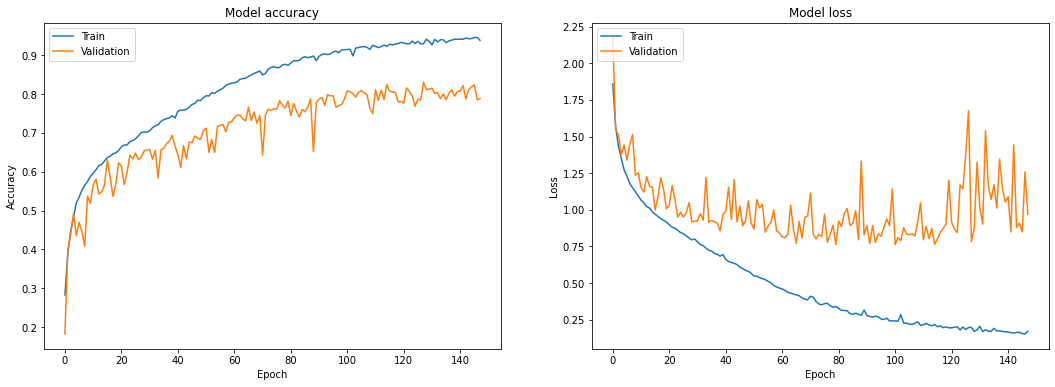

In [32]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize=(18, 6))

# Plot training & validation accuracy values

axes[0].plot(history.history['accuracy'])
axes[0].plot(history.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values

axes[1].plot(history.history['loss'])
axes[1].plot(history.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [34]:
from sklearn.metrics import accuracy_score

predictions = model.predict(val_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = val_generator.classes
class_names = val_generator.class_indices.keys()

print("Model Accuracy on test set: {:.4f}".format(accuracy_score(y_test, y_pred)))

Model Accuracy on test set: 0.7821


In [35]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.85      0.77       990
           1       0.78      0.79      0.79       162
           2       0.74      0.76      0.75      1025
           3       0.92      0.92      0.92      1796
           4       0.85      0.67      0.75      1734
           5       0.65      0.84      0.73       414
           6       0.56      0.56      0.56       602

    accuracy                           0.78      6723
   macro avg       0.74      0.77      0.75      6723
weighted avg       0.79      0.78      0.78      6723



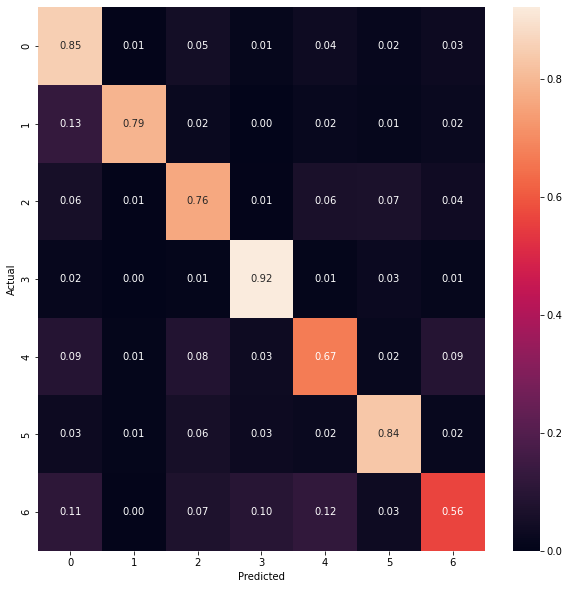

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [37]:
model_json = model.to_json()
with open("ferck_densenet_32.json", "w") as json_file:
    json_file.write(model_json)

In [38]:
#tidak dipakai karena data test sempat diperbaharui

from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen_test = ImageDataGenerator(featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        shear_range=.2,
                        horizontal_flip=True)

test_generator = datagen_test.flow_from_directory(test_dir,
                                                target_size=(48,48),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                color_mode='rgb',
                                                shuffle=False) 

Found 106 images belonging to 7 classes.


In [39]:
scores = model.evaluate(test_generator, verbose=1)
print("\nModel Evaluate Accuracy: %.2f%%" % (scores[1]*100))
print("Loss : ",scores[0])

4/4 [==============================] - 2s 639ms/step - loss: 1.2411 - accuracy: 0.7075

Model Evaluate Accuracy: 70.75%
Loss :  1.241129994392395


In [40]:
predictions = model.predict(test_generator)
Y_pred = [np.argmax(probas) for probas in predictions]
Y_test = test_generator.classes
class_names = test_generator.class_indices.keys()

print("Model Predict Accuracy on test set: {:.4f}".format(accuracy_score(Y_test, Y_pred)))

Model Predict Accuracy on test set: 0.7642


In [41]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85        15
           1       0.92      0.80      0.86        15
           2       0.56      0.67      0.61        15
           3       0.93      0.87      0.90        15
           4       0.62      0.62      0.62        16
           5       0.81      0.87      0.84        15
           6       0.82      0.60      0.69        15

    accuracy                           0.76       106
   macro avg       0.78      0.77      0.77       106
weighted avg       0.78      0.76      0.76       106



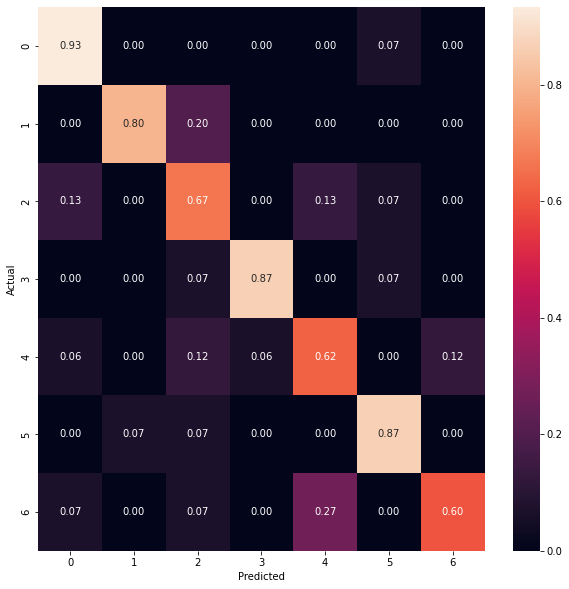

In [42]:
cm = confusion_matrix(Y_test, Y_pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)